<a href="https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/CLIP_Guided_Stable_diffusion_with_diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP Guided Stable Diffusion using [d🧨ffusers](https://github.com/huggingface/diffusers)

This notebook shows how to do CLIP guidance with Stable diffusion using diffusers libray. This allows you to use newly released [CLIP models by LAION AI.](https://huggingface.co/laion).

This notebook is based on the following amazing repos, all credits to the original authors!

- https://github.com/Jack000/glid-3-xl
- https://github.dev/crowsonkb/k-diffusion


### Initial Setup

In [ ]:
#@title Instal dependancies
!pip install -qqq diffusers transformers ftfy gradio

#### Authenticate with Hugging Face Hub

You have to be a registered user in 🤗 Hugging Face Hub, and enter your token. For the code to work you also need to read and accept the [Stable Diffusion model LICENSE](https://huggingface.co/CompVis/stable-diffusion-v1-4).

In [ ]:
#@title Login
from huggingface_hub import notebook_login

notebook_login()

### CLIP Guided Stable Diffusion

In [ ]:
#@title Define the Community Pipeline 
#@markdown This library is part of the [Diffusers Community Pipelines](https://github.com/huggingface/diffusers/tree/main/examples/community) library. If you modify or expand on it, feel free to share your pipeline to the community. 

import inspect
from typing import List, Optional, Union

import torch
from torch import nn
from torch.nn import functional as F

from diffusers import AutoencoderKL, DiffusionPipeline, LMSDiscreteScheduler, PNDMScheduler, UNet2DConditionModel
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion import StableDiffusionPipelineOutput
from torchvision import transforms
from transformers import CLIPFeatureExtractor, CLIPModel, CLIPTextModel, CLIPTokenizer


class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cut_power=1.0):
        super().__init__()

        self.cut_size = cut_size
        self.cut_power = cut_power

    def forward(self, pixel_values, num_cutouts):
        sideY, sideX = pixel_values.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(num_cutouts):
            size = int(torch.rand([]) ** self.cut_power * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = pixel_values[:, :, offsety : offsety + size, offsetx : offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)


def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)


def set_requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad = value


class CLIPGuidedStableDiffusion(DiffusionPipeline):
    """CLIP guided stable diffusion based on the amazing repo by @crowsonkb and @Jack000
    - https://github.com/Jack000/glid-3-xl
    - https://github.dev/crowsonkb/k-diffusion
    """

    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        clip_model: CLIPModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: Union[PNDMScheduler, LMSDiscreteScheduler],
        feature_extractor: CLIPFeatureExtractor,
    ):
        super().__init__()
        scheduler = scheduler.set_format("pt")
        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            clip_model=clip_model,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            feature_extractor=feature_extractor,
        )

        self.normalize = transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
        self.make_cutouts = MakeCutouts(feature_extractor.size)

        set_requires_grad(self.text_encoder, False)
        set_requires_grad(self.clip_model, False)

    def enable_attention_slicing(self, slice_size: Optional[Union[str, int]] = "auto"):
        if slice_size == "auto":
            # half the attention head size is usually a good trade-off between
            # speed and memory
            slice_size = self.unet.config.attention_head_dim // 2
        self.unet.set_attention_slice(slice_size)

    def disable_attention_slicing(self):
        self.enable_attention_slicing(None)

    def freeze_vae(self):
        set_requires_grad(self.vae, False)

    def unfreeze_vae(self):
        set_requires_grad(self.vae, True)

    def freeze_unet(self):
        set_requires_grad(self.unet, False)

    def unfreeze_unet(self):
        set_requires_grad(self.unet, True)

    @torch.enable_grad()
    def cond_fn(
        self,
        latents,
        timestep,
        index,
        text_embeddings,
        noise_pred_original,
        text_embeddings_clip,
        clip_guidance_scale,
        num_cutouts,
        use_cutouts=True,
    ):
        latents = latents.detach().requires_grad_()

        if isinstance(self.scheduler, LMSDiscreteScheduler):
            sigma = self.scheduler.sigmas[index]
            # the model input needs to be scaled to match the continuous ODE formulation in K-LMS
            latent_model_input = latents / ((sigma**2 + 1) ** 0.5)
        else:
            latent_model_input = latents

        # predict the noise residual
        noise_pred = self.unet(latent_model_input, timestep, encoder_hidden_states=text_embeddings).sample

        if isinstance(self.scheduler, PNDMScheduler):
            alpha_prod_t = self.scheduler.alphas_cumprod[timestep]
            beta_prod_t = 1 - alpha_prod_t
            # compute predicted original sample from predicted noise also called
            # "predicted x_0" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
            pred_original_sample = (latents - beta_prod_t ** (0.5) * noise_pred) / alpha_prod_t ** (0.5)

            fac = torch.sqrt(beta_prod_t)
            sample = pred_original_sample * (fac) + latents * (1 - fac)
        elif isinstance(self.scheduler, LMSDiscreteScheduler):
            sigma = self.scheduler.sigmas[index]
            sample = latents - sigma * noise_pred
        else:
            raise ValueError(f"scheduler type {type(self.scheduler)} not supported")

        sample = 1 / 0.18215 * sample
        image = self.vae.decode(sample).sample
        image = (image / 2 + 0.5).clamp(0, 1)

        if use_cutouts:
            image = self.make_cutouts(image, num_cutouts)
        else:
            image = transforms.Resize(self.feature_extractor.size)(image)
        image = self.normalize(image)

        image_embeddings_clip = self.clip_model.get_image_features(image).float()
        image_embeddings_clip = image_embeddings_clip / image_embeddings_clip.norm(p=2, dim=-1, keepdim=True)

        if use_cutouts:
            dists = spherical_dist_loss(image_embeddings_clip, text_embeddings_clip)
            dists = dists.view([num_cutouts, sample.shape[0], -1])
            loss = dists.sum(2).mean(0).sum() * clip_guidance_scale
        else:
            loss = spherical_dist_loss(image_embeddings_clip, text_embeddings_clip).mean() * clip_guidance_scale

        grads = -torch.autograd.grad(loss, latents)[0]

        if isinstance(self.scheduler, LMSDiscreteScheduler):
            latents = latents.detach() + grads * (sigma**2)
            noise_pred = noise_pred_original
        else:
            noise_pred = noise_pred_original - torch.sqrt(beta_prod_t) * grads
        return noise_pred, latents

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]],
        height: Optional[int] = 512,
        width: Optional[int] = 512,
        num_inference_steps: Optional[int] = 50,
        guidance_scale: Optional[float] = 7.5,
        clip_guidance_scale: Optional[float] = 100,
        clip_prompt: Optional[Union[str, List[str]]] = None,
        num_cutouts: Optional[int] = 4,
        use_cutouts: Optional[bool] = True,
        generator: Optional[torch.Generator] = None,
        latents: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
    ):
        if isinstance(prompt, str):
            batch_size = 1
        elif isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        if height % 8 != 0 or width % 8 != 0:
            raise ValueError(f"`height` and `width` have to be divisible by 8 but are {height} and {width}.")

        # get prompt text embeddings
        text_input = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]

        if clip_guidance_scale > 0:
            if clip_prompt is not None:
                clip_text_input = self.tokenizer(
                    clip_prompt,
                    padding="max_length",
                    max_length=self.tokenizer.model_max_length,
                    truncation=True,
                    return_tensors="pt",
                ).input_ids.to(self.device)
            else:
                clip_text_input = text_input.input_ids.to(self.device)
            text_embeddings_clip = self.clip_model.get_text_features(clip_text_input)
            text_embeddings_clip = text_embeddings_clip / text_embeddings_clip.norm(p=2, dim=-1, keepdim=True)

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            max_length = text_input.input_ids.shape[-1]
            uncond_input = self.tokenizer(
                [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
            )
            uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        # get the initial random noise unless the user supplied it

        # Unlike in other pipelines, latents need to be generated in the target device
        # for 1-to-1 results reproducibility with the CompVis implementation.
        # However this currently doesn't work in `mps`.
        latents_device = "cpu" if self.device.type == "mps" else self.device
        latents_shape = (batch_size, self.unet.in_channels, height // 8, width // 8)
        if latents is None:
            latents = torch.randn(
                latents_shape,
                generator=generator,
                device=latents_device,
            )
        else:
            if latents.shape != latents_shape:
                raise ValueError(f"Unexpected latents shape, got {latents.shape}, expected {latents_shape}")
        latents = latents.to(self.device)

        # set timesteps
        accepts_offset = "offset" in set(inspect.signature(self.scheduler.set_timesteps).parameters.keys())
        extra_set_kwargs = {}
        if accepts_offset:
            extra_set_kwargs["offset"] = 1

        self.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)

        # if we use LMSDiscreteScheduler, let's make sure latents are multiplied by sigmas
        if isinstance(self.scheduler, LMSDiscreteScheduler):
            latents = latents * self.scheduler.sigmas[0]

        for i, t in enumerate(self.progress_bar(self.scheduler.timesteps)):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
            if isinstance(self.scheduler, LMSDiscreteScheduler):
                sigma = self.scheduler.sigmas[i]
                # the model input needs to be scaled to match the continuous ODE formulation in K-LMS
                latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

            # # predict the noise residual
            noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

            # perform classifier free guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # perform clip guidance
            if clip_guidance_scale > 0:
                text_embeddings_for_guidance = (
                    text_embeddings.chunk(2)[1] if do_classifier_free_guidance else text_embeddings
                )
                noise_pred, latents = self.cond_fn(
                    latents,
                    t,
                    i,
                    text_embeddings_for_guidance,
                    noise_pred,
                    text_embeddings_clip,
                    clip_guidance_scale,
                    num_cutouts,
                    use_cutouts,
                )

            # compute the previous noisy sample x_t -> x_t-1
            if isinstance(self.scheduler, LMSDiscreteScheduler):
                latents = self.scheduler.step(noise_pred, i, latents).prev_sample
            else:
                latents = self.scheduler.step(noise_pred, t, latents).prev_sample

        # scale and decode the image latents with vae
        latents = 1 / 0.18215 * latents
        image = self.vae.decode(latents).sample

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()

        if output_type == "pil":
            image = self.numpy_to_pil(image)

        if not return_dict:
            return (image, None)

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=None)


In [ ]:
#@title Load the pipeline
import torch
from diffusers import LMSDiscreteScheduler, StableDiffusionPipeline
from PIL import Image
from transformers import CLIPFeatureExtractor, CLIPModel

model_id = "CompVis/stable-diffusion-v1-4" #@param {type: "string"}
clip_model_id = "laion/CLIP-ViT-B-32-laion2B-s34B-b79K" #@param ["laion/CLIP-ViT-B-32-laion2B-s34B-b79K", "laion/CLIP-ViT-L-14-laion2B-s32B-b82K", "laion/CLIP-ViT-H-14-laion2B-s32B-b79K", "laion/CLIP-ViT-g-14-laion2B-s12B-b42K", "openai/clip-vit-base-patch32", "openai/clip-vit-base-patch16", "openai/clip-vit-large-patch14"] {allow-input: true}
scheduler = "plms" #@param ['plms', 'lms']


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def create_clip_guided_pipeline(
    model_id="CompVis/stable-diffusion-v1-4", clip_model_id="laion/CLIP-ViT-B-32-laion2B-s34B-b79K", scheduler="plms"
):
    pipeline = StableDiffusionPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        revision="fp16",
        use_auth_token=True,
    )

    if scheduler == "lms":
        scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear")
    else:
        scheduler = pipeline.scheduler

    clip_model = CLIPModel.from_pretrained(clip_model_id, torch_dtype=torch.float16)
    feature_extractor = CLIPFeatureExtractor.from_pretrained(clip_model_id, torch_dtype=torch.float16)

    guided_pipeline = CLIPGuidedStableDiffusion(
        unet=pipeline.unet,
        vae=pipeline.vae,
        tokenizer=pipeline.tokenizer,
        text_encoder=pipeline.text_encoder,
        scheduler=scheduler,
        clip_model=clip_model,
        feature_extractor=feature_extractor,
    )

    return guided_pipeline

guided_pipeline = create_clip_guided_pipeline(model_id, clip_model_id)
guided_pipeline = guided_pipeline.to("cuda")

In [ ]:
#@title Generate with Gradio Demo

import gradio as gr

import torch
from torch import autocast
from diffusers import StableDiffusionPipeline
from PIL import Image  


last_model = "laion/CLIP-ViT-B-32-laion2B-s34B-b79K"
def infer(prompt, clip_prompt, samples, steps, clip_scale, scale, seed, clip_model, use_cutouts, num_cutouts):
    global last_model
    print(last_model)
    if(last_model == clip_model):
      guided_pipeline = create_clip_guided_pipeline(model_id, clip_model_id)
      guided_pipeline = guided_pipeline.to("cuda")
      last_model = clip_model
    prompt = prompt
    clip_prompt = clip_prompt
    num_samples = samples
    num_inference_steps = steps
    guidance_scale = scale
    clip_guidance_scale = clip_scale 
    if(use_cutouts):
      use_cutouts = "True"
    else:
       use_cutouts = "False"
    unfreeze_unet = "True" 
    unfreeze_vae = "True" 
    seed = seed

    if unfreeze_unet == "True":
        guided_pipeline.unfreeze_unet()
    else:
        guided_pipeline.freeze_unet()

    if unfreeze_vae == "True":
        guided_pipeline.unfreeze_vae()
    else:
        guided_pipeline.freeze_vae()

    generator = torch.Generator(device="cuda").manual_seed(seed)

    images = []
    for i in range(num_samples):
        with torch.autocast("cuda"):
            image = guided_pipeline(
                prompt,
                clip_prompt=clip_prompt if clip_prompt.strip() != "" else None,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale, 
                clip_guidance_scale=clip_guidance_scale,
                num_cutouts=num_cutouts,
                use_cutouts=use_cutouts == "True",
                generator=generator,
            ).images[0]
        images.append(image)

    #image_grid(images, 1, num_samples)
    return images
    
css = """
        .gradio-container {
            font-family: 'IBM Plex Sans', sans-serif;
        }
        .gr-button {
            color: white;
            border-color: black;
            background: black;
        }
        input[type='range'] {
            accent-color: black;
        }
        .dark input[type='range'] {
            accent-color: #dfdfdf;
        }
        .container {
            max-width: 730px;
            margin: auto;
            padding-top: 1.5rem;
        }
        #gallery {
            min-height: 22rem;
            margin-bottom: 15px;
            margin-left: auto;
            margin-right: auto;
            border-bottom-right-radius: .5rem !important;
            border-bottom-left-radius: .5rem !important;
        }
        #gallery>div>.h-full {
            min-height: 20rem;
        }
        .details:hover {
            text-decoration: underline;
        }
        .gr-button {
            white-space: nowrap;
        }
        .gr-button:focus {
            border-color: rgb(147 197 253 / var(--tw-border-opacity));
            outline: none;
            box-shadow: var(--tw-ring-offset-shadow), var(--tw-ring-shadow), var(--tw-shadow, 0 0 #0000);
            --tw-border-opacity: 1;
            --tw-ring-offset-shadow: var(--tw-ring-inset) 0 0 0 var(--tw-ring-offset-width) var(--tw-ring-offset-color);
            --tw-ring-shadow: var(--tw-ring-inset) 0 0 0 calc(3px var(--tw-ring-offset-width)) var(--tw-ring-color);
            --tw-ring-color: rgb(191 219 254 / var(--tw-ring-opacity));
            --tw-ring-opacity: .5;
        }
        #advanced-btn {
            font-size: .7rem !important;
            line-height: 19px;
            margin-top: 12px;
            margin-bottom: 12px;
            padding: 2px 8px;
            border-radius: 14px !important;
        }
        #advanced-options {
            display: none;
            margin-bottom: 20px;
        }
        .footer {
            margin-bottom: 45px;
            margin-top: 35px;
            text-align: center;
            border-bottom: 1px solid #e5e5e5;
        }
        .footer>p {
            font-size: .8rem;
            display: inline-block;
            padding: 0 10px;
            transform: translateY(10px);
            background: white;
        }
        .dark .footer {
            border-color: #303030;
        }
        .dark .footer>p {
            background: #0b0f19;
        }
        .acknowledgments h4{
            margin: 1.25em 0 .25em 0;
            font-weight: bold;
            font-size: 115%;
        }
"""

block = gr.Blocks(css=css)

examples = [
    [
        'A high tech solarpunk utopia in the Amazon rainforest',
        2,
        45,
        7.5,
        1024,
    ],
    [
        'A pikachu fine dining with a view to the Eiffel Tower',
        2,
        45,
        7,
        1024,
    ],
    [
        'A mecha robot in a favela in expressionist style',
        2,
        45,
        7,
        1024,
    ],
    [
        'an insect robot preparing a delicious meal',
        2,
        45,
        7,
        1024,
    ],
    [
        "A small cabin on top of a snowy mountain in the style of Disney, artstation",
        2,
        45,
        7,
        1024,
    ],
]

with block:
    gr.HTML(
        """
            <div style="text-align: center; max-width: 650px; margin: 0 auto;">
              <div
                style="
                  display: inline-flex;
                  align-items: center;
                  gap: 0.8rem;
                  font-size: 1.75rem;
                "
              >
                <svg
                  width="0.65em"
                  height="0.65em"
                  viewBox="0 0 115 115"
                  fill="none"
                  xmlns="http://www.w3.org/2000/svg"
                >
                  <rect width="23" height="23" fill="white"></rect>
                  <rect y="69" width="23" height="23" fill="white"></rect>
                  <rect x="23" width="23" height="23" fill="#AEAEAE"></rect>
                  <rect x="23" y="69" width="23" height="23" fill="#AEAEAE"></rect>
                  <rect x="46" width="23" height="23" fill="white"></rect>
                  <rect x="46" y="69" width="23" height="23" fill="white"></rect>
                  <rect x="69" width="23" height="23" fill="black"></rect>
                  <rect x="69" y="69" width="23" height="23" fill="black"></rect>
                  <rect x="92" width="23" height="23" fill="#D9D9D9"></rect>
                  <rect x="92" y="69" width="23" height="23" fill="#AEAEAE"></rect>
                  <rect x="115" y="46" width="23" height="23" fill="white"></rect>
                  <rect x="115" y="115" width="23" height="23" fill="white"></rect>
                  <rect x="115" y="69" width="23" height="23" fill="#D9D9D9"></rect>
                  <rect x="92" y="46" width="23" height="23" fill="#AEAEAE"></rect>
                  <rect x="92" y="115" width="23" height="23" fill="#AEAEAE"></rect>
                  <rect x="92" y="69" width="23" height="23" fill="white"></rect>
                  <rect x="69" y="46" width="23" height="23" fill="white"></rect>
                  <rect x="69" y="115" width="23" height="23" fill="white"></rect>
                  <rect x="69" y="69" width="23" height="23" fill="#D9D9D9"></rect>
                  <rect x="46" y="46" width="23" height="23" fill="black"></rect>
                  <rect x="46" y="115" width="23" height="23" fill="black"></rect>
                  <rect x="46" y="69" width="23" height="23" fill="black"></rect>
                  <rect x="23" y="46" width="23" height="23" fill="#D9D9D9"></rect>
                  <rect x="23" y="115" width="23" height="23" fill="#AEAEAE"></rect>
                  <rect x="23" y="69" width="23" height="23" fill="black"></rect>
                </svg>
                <h1 style="font-weight: 900; margin-bottom: 7px;">
                  CLIP Guided Stable Diffusion Demo
                </h1>
              </div>
              <p style="margin-bottom: 10px; font-size: 94%">
               Demo allows you to use newly released <a href="https://huggingface.co/laion" style="text-decoration: underline">CLIP models by LAION AI</a> with Stable Diffusion
              </p>
            </div>
        """
    )
    with gr.Group():
        with gr.Box():
            with gr.Row().style(mobile_collapse=False, equal_height=True):
                text = gr.Textbox(
                    label="Enter your prompt",
                    show_label=False,
                    max_lines=1,
                    placeholder="Enter your prompt",
                ).style(
                    border=(True, False, True, True),
                    rounded=(True, False, False, True),
                    container=False,
                )
                btn = gr.Button("Generate image").style(
                    margin=False,
                    rounded=(False, True, True, False),
                )

        gallery = gr.Gallery(
            label="Generated images", show_label=False, elem_id="gallery"
        ).style(grid=[2], height="auto")

        advanced_button = gr.Button("Advanced options", elem_id="advanced-btn")

        with gr.Row(elem_id="advanced-options"):
            with gr.Column():
              clip_prompt = gr.Textbox(
                      label="Enter a CLIP prompt if you want it to differ",
                      show_label=False,
                      max_lines=1,
                      placeholder="Enter a CLIP prompt if you want it to differ",
              )
              with gr.Row():
                samples = gr.Slider(label="Images", minimum=1, maximum=2, value=1, step=1)
                steps = gr.Slider(label="Steps", minimum=1, maximum=50, value=45, step=1)
              with gr.Row():
                use_cutouts = gr.Checkbox(label="Use cutouts?")
                num_cutouts = gr.Slider(label="Cutouts", minimum=1, maximum=16, value=4, step=1)
            with gr.Row():
              with gr.Column():
                clip_model = gr.Dropdown(["laion/CLIP-ViT-B-32-laion2B-s34B-b79K", "laion/CLIP-ViT-L-14-laion2B-s32B-b82K", "laion/CLIP-ViT-H-14-laion2B-s32B-b79K", "laion/CLIP-ViT-g-14-laion2B-s12B-b42K", "openai/clip-vit-base-patch32", "openai/clip-vit-base-patch16", "openai/clip-vit-large-patch14"], value="laion/CLIP-ViT-B-32-laion2B-s34B-b79K", show_label=False)
                with gr.Row():
                  scale = gr.Slider(
                      label="Guidance Scale", minimum=0, maximum=50, value=7.5, step=0.1
                  )
                  seed = gr.Slider(
                      label="Seed",
                      minimum=0,
                      maximum=2147483647,
                      step=1,
                      randomize=True,
                  )
                  clip_scale = gr.Slider(
                      label="CLIP Guidance Scale", minimum=0, maximum=5000, value=100, step=1
                  )

        ex = gr.Examples(examples=examples, fn=infer, inputs=[text, samples, steps, scale, clip_scale, seed], outputs=gallery, cache_examples=False)
        ex.dataset.headers = [""]

        
        text.submit(infer, inputs=[text, clip_prompt, samples, steps, scale, clip_scale, seed, clip_model, use_cutouts, num_cutouts], outputs=gallery)
        btn.click(infer, inputs=[text, clip_prompt, samples, steps, scale, clip_scale, seed, clip_model, use_cutouts, num_cutouts], outputs=gallery)
        advanced_button.click(
            None,
            [],
            text,
            _js="""
            () => {
                const options = document.querySelector("body > gradio-app").querySelector("#advanced-options");
                options.style.display = ["none", ""].includes(options.style.display) ? "flex" : "none";
            }""",
        )
        gr.HTML(
            """
                <div class="footer">
                    <p>Model by <a href="https://huggingface.co/CompVis" style="text-decoration: underline;" target="_blank">CompVis</a> and <a href="https://huggingface.co/stabilityai" style="text-decoration: underline;" target="_blank">Stability AI</a> - Gradio Demo by 🤗 Hugging Face
                    </p>
                </div>
                <div class="acknowledgments">
                    <p><h4>LICENSE</h4>
The model is licensed with a <a href="https://huggingface.co/spaces/CompVis/stable-diffusion-license" style="text-decoration: underline;" target="_blank">CreativeML Open RAIL-M</a> license. The authors claim no rights on the outputs you generate, you are free to use them and are accountable for their use which must not go against the provisions set in this license. The license forbids you from sharing any content that violates any laws, produce any harm to a person, disseminate any personal information that would be meant for harm, spread misinformation and target vulnerable groups. For the full list of restrictions please <a href="https://huggingface.co/spaces/CompVis/stable-diffusion-license" target="_blank" style="text-decoration: underline;" target="_blank">read the license</a></p>
                    <p><h4>Biases and content acknowledgment</h4>
Despite how impressive being able to turn text into image is, beware to the fact that this model may output content that reinforces or exacerbates societal biases, as well as realistic faces, pornography and violence. The model was trained on the <a href="https://laion.ai/blog/laion-5b/" style="text-decoration: underline;" target="_blank">LAION-5B dataset</a>, which scraped non-curated image-text-pairs from the internet (the exception being the removal of illegal content) and is meant for research purposes. You can read more in the <a href="https://huggingface.co/CompVis/stable-diffusion-v1-4" style="text-decoration: underline;" target="_blank">model card</a></p>
               </div>
           """
        )

block.launch(debug=True)

  0%|          | 0/51 [00:00<?, ?it/s]

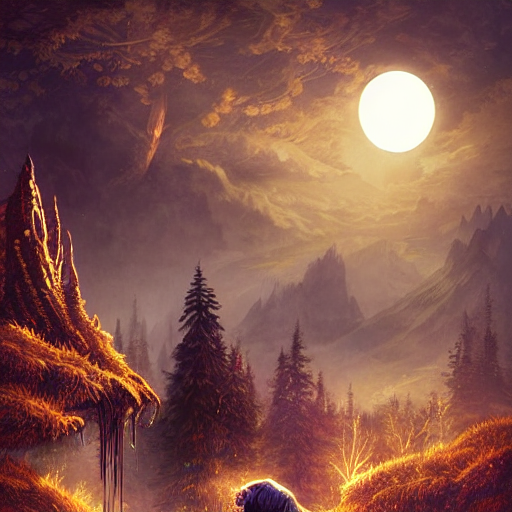

In [ ]:
#@title Generate on Colab

prompt = "fantasy book cover, full moon, fantasy forest landscape, golden vector elements, fantasy magic, dark light night, intricate, elegant, sharp focus, illustration, highly detailed, digital painting, concept art, matte, art by WLOP and Artgerm and Albert Bierstadt, masterpiece" #@param {type: "string"}
#@markdown `clip_prompt` is optional, if you leave it blank the same prompt is sent to Stable Diffusion and CLIP
clip_prompt = "" #@param {type: "string"}
num_samples = 1 #@param {type: "number"}
num_inference_steps = 50 #@param {type: "number"}
guidance_scale = 7.5 #@param {type: "number"}
clip_guidance_scale = 100 #@param {type: "number"}
num_cutouts = 4 #@param {type: "number"}
use_cutouts = "False" #@param ["False", "True"]
unfreeze_unet = "True" #@param ["False", "True"]
unfreeze_vae = "True" #@param ["False", "True"]
seed = 3788086447 #@param {type: "number"}

if unfreeze_unet == "True":
  guided_pipeline.unfreeze_unet()
else:
  guided_pipeline.freeze_unet()

if unfreeze_vae == "True":
  guided_pipeline.unfreeze_vae()
else:
  guided_pipeline.freeze_vae()

generator = torch.Generator(device="cuda").manual_seed(seed)

images = []
for i in range(num_samples):
    with torch.autocast("cuda"):
        image = guided_pipeline(
            prompt,
            clip_prompt=clip_prompt if clip_prompt.strip() != "" else None,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale, 
            clip_guidance_scale=clip_guidance_scale,
            num_cutouts=num_cutouts,
            use_cutouts=use_cutouts == "True",
            generator=generator,
        ).images[0]
    images.append(image)

image_grid(images, 1, num_samples)